In [1]:
import os

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from adjustText import adjust_text

from Bio import SeqIO

from scipy import stats
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


In [2]:
datadir = '../data/dnaPipeTE-out'
dnapipete_data = {sp: f'{datadir}/{sp}/Counts.txt' for sp in os.listdir(datadir)}

In [3]:
def read_counts(countfile):
    count_df = pd.read_csv(countfile, sep='\t', header=None, names=['teclass', 'readcount'])
    return count_df

def count_finz_znf(species):
    count = 0
    with open('../data/seqs/cypriniformes_augustus_finz.fa') as infile:
        for line in infile:
            if line.startswith(f'>{species}'):
                count += 1
    return count

def count_finz_exons(species):
    count = 0
    with open(f'../data/blast-out/{species}_finz_locs.out') as infile:
        for line in infile:
            count += 1
    return count

In [4]:
count_dfs = []
for sp, val in dnapipete_data.items():
    count_df = read_counts(val)
    count_df['species'] = sp
    count_df['finz_znf'] = count_finz_znf(sp)
    count_df['finz_exons'] = count_finz_exons(sp)
    count_dfs.append(count_df)

count_df = pd.concat(count_dfs)
count_df = count_df.pivot_table(index=['species', 'finz_exons', 'finz_znf'], 
                                columns='teclass', 
                                values='readcount') \
    .sort_values('finz_znf') \
    .reset_index()
count_df['Unknown'] = count_df.na + count_df.others
count_df = count_df.drop(['Others', 'Tandem_repeats', 'na', 'others', 'rRNA', 'MITE', 'Simple_repeat'], axis=1)
count_df['interspersed'] = count_df.DNA + count_df.LTR + count_df.LINE + count_df.SINE + count_df.Helitron + count_df.Unknown

# gsizes = []
# specieslist = []
# for species in count_df.species:
#     with open(f'../data/beds/{species}.genome') as infile:
#         gsizes.append(sum(int(line.split()[1]) for line in infile))
#         specieslist.append(species)
# count_df = count_df.merge(pd.DataFrame({'species':specieslist, 'gsizes':gsizes}), on='species')

for teclass in ['DNA', 'Helitron', 'LINE', 'LTR', 'SINE', 'Low_Complexity', 'Satellite', 'Unknown', 'interspersed', 'Total']:
    count_df[teclass] = count_df[teclass]/count_df['Total']*100

print(count_df.head())
# print(gsizes_df.head())
# count_df.to_csv('../data/finz_te_counts.txt', sep='\t', header=True, index=False)

teclass                    species  finz_exons  finz_znf        DNA  Helitron  \
0             Triplophysa_tibetana          35         0  11.535100  0.353564   
1              Triplophysa_dalaica           0         0  11.008990  0.674275   
2        Paedocypris_micromegethes           0         0   7.697244  0.042865   
3          Paedocypris_carbunculus           0         0   7.279874  0.039627   
4           Triplophysa_siluroides          14         0  11.144761  0.165809   

teclass      LINE       LTR  Low_Complexity      SINE  Satellite  Total  \
0        4.109580  4.397636        0.046156  0.414028   0.150996  100.0   
1        4.105306  3.831425        0.043453  0.407826   0.320071  100.0   
2        1.871420  0.819487        0.081823  0.687823   0.041734  100.0   
3        1.855833  0.837787        0.096460  0.458067   0.031056  100.0   
4        2.899348  4.312603        0.036850  0.296132   0.086445  100.0   

teclass   Unknown  interspersed  
0        8.651206     29.461

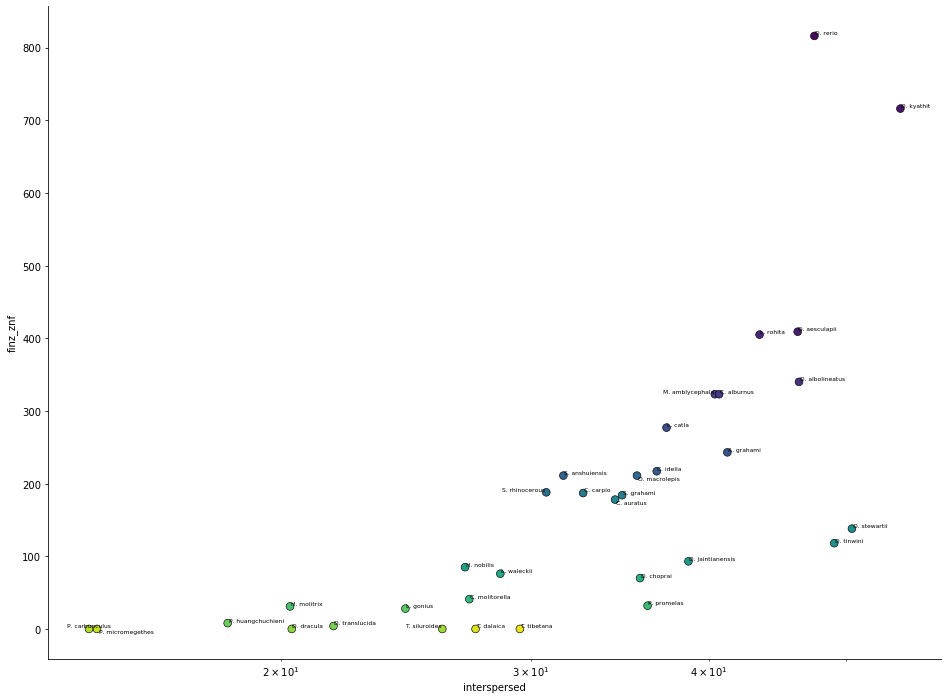

SpearmanrResult(correlation=0.8142222246182216, pvalue=4.697823788917326e-09)


In [6]:
column = 'interspersed'
fig, ax = plt.subplots(figsize=(16, 12))
sns.scatterplot(data=count_df, 
                x=column, 
                y='finz_znf',
                hue='species',
                palette='viridis_r',
                edgecolor='k',
                s=60,
                ax=ax)
ax.get_legend().remove()
ax.set_xscale('log')

labels = []
for row in count_df.iterrows():
    label = row[1]['species'].split('_')[0][0] +'. '+ row[1]['species'].split('_')[1]
    labels.append(ax.text(row[1][column], row[1]['finz_znf'], label, size=6, va='center', ha='center'))
adjust_text(labels)

sns.despine()
plt.show()
print(stats.spearmanr(count_df[column], 
                      count_df['finz_znf']))

fig.savefig('../figs/finz_znf_corr.pdf', bbox_inches='tight')

A possible explanation for some of the noise in the correlation is genome assembly quality. Since the finz-znfs are normally present on specific, highly repetitive chromosomes, it is possible that low numbers of predicted genes could be due to collapsing or fragmentation of these regions. To test this, we will look at the correlation between N50 and finz count.

In [7]:
def calc_N50(genomefile):
    contiglens = []
    for record in SeqIO.parse(genomefile, 'fasta'):
        contiglens.append(len(record.seq))
    contiglens = sorted(contiglens, reverse=True)
    gsize = sum(contiglens)
    i, currentsize = 0, 0
    while currentsize <= gsize*0.5:
        currentsize += contiglens[i]
        i += 1
    return contiglens[i]

with open('../data/species_genomes.txt') as infile:
    genomes = {line.split()[0]: f'/Users/jonwells/Genomes/Cypriniformes/ncbi-genomes-2020-07-09/{line.split()[1]}' for line in infile}
genomes.pop('Chanos_chanos')


n50s = []
for species, genomefile in genomes.items():
    n50s.append((species, calc_N50(genomefile)))
n50_df = pd.DataFrame(n50s, columns=['species', 'N50'])
# n50_df = n50_df.merge(count_df, on='species')
print(n50_df.head())

                        species      N50
0           Pimephales_promelas    60365
1               Cyprinus_carpio  7653411
2       Ctenopharyngodon_idella  6014843
3  Sinocyclocheilus_anshuiensis  1282074
4  Sinocyclocheilus_rhinocerous   945578


In [8]:
n50_df = n50_df[['species', 'N50']]
n50_df = n50_df.merge(count_df, on='species')
n50_df.to_csv('../data/finz_te_counts.txt', sep='\t', header=True, index=False)

In [21]:
print(n50_df.loc[n50_df.species.str.startswith('Triplophysa')])

                   species       N50  finz_exons  finz_znf        DNA  \
16  Triplophysa_siluroides   2829549          14         0  11.144761   
17    Triplophysa_tibetana  24589443          35         0  11.535100   
18     Triplophysa_dalaica  23332616           0         0  11.008990   

    Helitron      LINE       LTR  Low_Complexity      SINE  Satellite  Total  \
16  0.165809  2.899348  4.312603        0.036850  0.296132   0.086445  100.0   
17  0.353564  4.109580  4.397636        0.046156  0.414028   0.150996  100.0   
18  0.674275  4.105306  3.831425        0.043453  0.407826   0.320071  100.0   

     Unknown  interspersed  
16  7.162924     25.981576  
17  8.651206     29.461116  
18  7.392584     27.420406  


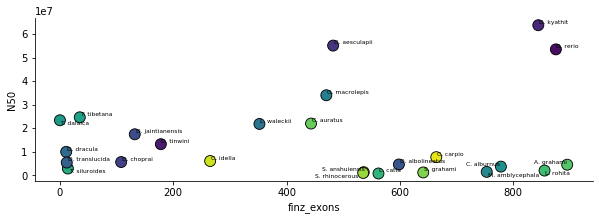

SpearmanrResult(correlation=-0.21615384615384614, pvalue=0.2993767800206253)


In [17]:
min_N50 = 5e05
column = 'finz_exons'

# fig, ax = plt.subplots(figsize=(8, 7)) 
# sns.scatterplot(data=n50_df, 
#                 x='N50', 
#                 y=column,
#                 hue='species',
#                 palette='viridis_r',
#                 edgecolor='k',
#                 s=120,
#                 ax=ax)
# ax.axvline(x=min_N50)
# ax.set_xscale('log')
# ax.get_legend().remove()

# labels = []
# for row in n50_df.iterrows():
#     label = row[1]['species'].split('_')[0][0] +'. '+ row[1]['species'].split('_')[1]
#     labels.append(ax.text(row[1]['N50'], row[1][column], label, size=6, va='center', ha='center'))
# adjust_text(labels)

# sns.despine()
# plt.show()
# print(stats.spearmanr(n50_df.loc[n50_df['N50'] >= min_N50].N50, n50_df.loc[n50_df['N50'] >= min_N50][column]))
# print(stats.spearmanr(n50_df.loc[n50_df['N50'] >= min_N50].N50, n50_df.loc[n50_df['N50'] >= min_N50].interspersed))

fig, ax = plt.subplots(figsize=(10, 3)) 
sns.scatterplot(data=n50_df.loc[n50_df['N50'] >= min_N50], 
                y='N50', 
                x=column,
                hue='species',
                palette='viridis_r',
                edgecolor='k',
                s=120,
                ax=ax)
ax.get_legend().remove()

labels = []
for row in n50_df.loc[n50_df['N50'] >= min_N50].iterrows():
    label = row[1]['species'].split('_')[0][0] +'. '+ row[1]['species'].split('_')[1]
    labels.append(ax.text(row[1][column], row[1]['N50'], label, size=6, va='center', ha='center'))
adjust_text(labels)

sns.despine()
plt.show()

print(stats.spearmanr(n50_df.loc[n50_df['N50'] >= min_N50].N50, n50_df.loc[n50_df['N50'] >= min_N50][column]))

In [29]:
print(n50_df.loc[n50_df['N50'] >= min_N50].reset_index().species)
n50_df.loc[n50_df['N50'] >= min_N50].reset_index()[['species']].to_csv('../data/n50_gt5e05.txt', header=False, index=False)

0                  Cyprinus_carpio
1          Ctenopharyngodon_idella
2     Sinocyclocheilus_anshuiensis
3     Sinocyclocheilus_rhinocerous
4         Sinocyclocheilus_grahami
5                Carassius_auratus
6              Anabarilius_grahami
7                     Labeo_rohita
8                      Labeo_catla
9           Triplophysa_siluroides
10            Triplophysa_tibetana
11             Triplophysa_dalaica
12                 Culter_alburnus
13        Megalobrama_amblycephala
14          Onychostoma_macrolepis
15              Leuciscus_waleckii
16              Danionella_dracula
17          Danionella_translucida
18              Danio_albolineatus
19             Danio_jaintianensis
20                   Danio_choprai
21                Danio_aesculapii
22                   Danio_kyathit
23                   Danio_tinwini
24                     Danio_rerio
Name: species, dtype: object
